In [1]:
%config InlineBackend.figure_format='svg'
import matplotlib
matplotlib.use("nbagg")
from matplotlib.pyplot import *
from numpy import *
%matplotlib inline  

import urllib2
import datetime
import time
import urllib, json, datetime, calendar
import archivedb
import PIL.Image
import tables

import random
np.set_printoptions(threshold=5)

# Python module Archivedb
AIMS-
To find the time intervals where signals exist in the database. To read and write signals, images and parameters of datastreams, to/from the database. To use Library cache for faster processing and usage of database even in the absence of network.

To use this library the following notions are required:

Signal: Of the form View --> Project --> Stream Group --> Stream --> Channel-Number --> Channel-Name. Stored in database along with the corresponding timestamps.

Timestamp: W7-X timestamps are 64-bit integer values representing the nanoseconds since 1970-01-01 in UTC.

# Signal names

* string copied from web - Database/View/Project/StreamGroup/Stream_DATASTREAM/Channel #/Channel Name
* list form ["Database", "View", "Project", "StreamGroup", "Stream_DATASTREAM", "Channel #", "Channel Name"]

The library can accept signal name in several forms:

**Form 1**: ArchiveDB/raw/W7X/CoDaStationDesc.84/DataModuleDesc.187_DATASTREAM/0/Current of  nonplanar Coils type 1 (AAE10)

**Form 2**: http://archive-webapi.ipp-hgw.mpg.de/ArchiveDB/raw/W7X/CoDaStationDesc.84/DataModuleDesc.187_DATASTREAM/0/Current%20of%20%20nonplanar%20Coils%20type%201%20(AAE10)

**Form 3**: ["ArchiveDB","raw","W7X","CoDaStationDesc.84","DataModuleDesc.187_DATASTREAM","0","Current of  nonplanar Coils type 1 (AAE10)"]

**Form 4**: ["http://archive-webapi.ipp-hgw.mpg.de", "ArchiveDB","raw","W7X","CoDaStationDesc.84",
"DataModuleDesc.187_DATASTREAM","0","Current of  nonplanar Coils type 1 (AAE10)"] 

# Time intervals

ArchiveDB works with nanosecond precise timestamps. This library has help functions to convert string times to and from the time stamp form. Also there are methods to find out valid time intervals for a signal.

* conversion of readable times to timestamps and back
* requesting DB for valid time intervals
* finding the last valid time interval
* possible to request data for arbitrary time intervals, but better for our caching to use these time windows

## Convert to/from timestamps

The library has function for converting human readable time strings to and from timestamps.
Accepted string forms are:

**Form 1:** "YYYY-MM-DD HH:MM:SS"

**Form 2:** "YYYY-MM-DD HH:MM:SS.%f"

The String dates are converted to UTC timestamps in nanoseconds.

The nanoseconds can be converted back to get the corressponding string dates.

In [39]:
print archivedb.to_timestamp("2015-08-20 12:37:33")
print archivedb.to_timestamp("2015-08-20 12:37:33.3456")

print archivedb.to_stringdate(1440074253345600000)

1440074253000000000
1440074253345600000
2015-08-20 12:37:33.345600


## Request valid intervals

ArchiveDB saves data in chunks (time intervals) these methods help to find valid intervals for a given signal. It is possible to request the database for an arbitrary interval. For the library caching it is better to stick to requesting valid time intervals.

1. Last fifty time intervals in a given time window (if there are more than 50 intervals).
2. All time intervals in  a given time window (irrespective of the number of time intervals existing).
3. Last valid time interval

Note: Intervals returned start with the latest and go on to the oldest time interval.

Example: [[49, 50],[47, 48],...,[1, 2]]
If 1 to 50 were timestamps

In [2]:
signal = "ArchiveDB/raw/W7X/CoDaStationDesc.84/DataModuleDesc.187_DATASTREAM/0/Current of  nonplanar Coils type 1 (AAE10)"

print "Last Fifty intervals:", "\n", archivedb.get_lastfifty_time_intervals(signal,"2015-07-22 14:14:33","2015-08-13 14:20:33"),"\n"
print "All intervals:", "\n", archivedb.get_all_time_intervals(signal, "2015-07-22 14:07:33","2015-08-13 14:20:33"), "\n"
print "Latest time interval:", archivedb.get_latest_time_interval(signal)

Last Fifty intervals: 
[[1437574835231205506 1437574836226205507]
 [1437574805231205506 1437574835226205507]
 [1437574775231205506 1437574805226205507]
 ..., 
 [1437574511231205506 1437574541226205507]
 [1437574481231205506 1437574511226205507]
 [1437574473000000000 1437574481226205507]] 

All intervals: 
[[1437574835231205506 1437574836226205507]
 [1437574805231205506 1437574835226205507]
 [1437574775231205506 1437574805226205507]
 ..., 
 [1437574091231205506 1437574121226205507]
 [1437574061231205506 1437574091226205507]
 [1437574053000000000 1437574061226205507]] 

Latest time interval: [1439872790236205506 1439872800226205507]


# Signal data

The library provides methods for reading and writing signals from/to the database. It is possible to read all channels of a single datastream ("acquisition card") at the same time. The latter case is known as a signal box - a set of channels.
To request a signal data one needs a valid signal name and time intervals in terms of time stamps.

* reading out a single time interval for a single channel
* reading multiple intervals for a single channel
* reading signal box for multiple channels, single interval
* reading signal box  for multiple intervals
* library local caching
* write signals into test datatabase

## Single channel, single interval

First find the time interval, e.g. last time interval, where the signal exists.
Then pass the interval to get the signal values in the interval.

Returns: The timestamp array and the signal values at those timestamps. 

Note: The following example first finds the last time interval where the signal values exist. Then we find the signal values for that interval

In [75]:
signal = "ArchiveDB/raw/W7X/CoDaStationDesc.84/DataModuleDesc.187_DATASTREAM/0/Current of  nonplanar Coils type 1 (AAE10)"

interval = archivedb.get_latest_time_interval(signal)
times, values = archivedb.get_signal(signal, interval[0], interval[1])

print "Timestamps: ", times, "\n"
print "Values: ", values

Timestamps:  [1439872790236205507 1439872790241205507 1439872790246205507 ...,
 1439872800216205507 1439872800221205507 1439872800226205507] 

Values:  [ 2.6856287  -2.1515553  -0.946074   ...,  1.7242956  -1.2512584
 -0.16785137]


## Single channel,  many intervals

First find the time intervals, e.g. find all time intervals, where the signal exists.

Then pass the array of intervals(i.e. the 2d array) to get the signal values in the intervals.

Note: The intervals (2d array) will be of the form [[49,50],[47, 48],...,[1,2]]. (in descending order, the lastest interval first)  
If 1 to 50 were timestamps

But the timestamps returned by the get_all_signal function will be in ascending order of the timestamps.
Of the form: 1, 2, 3, ..., 49, 50.
If 1 to 50 were timestamps.

The signal array contains the signal values corresponding to the ascending order of timestamps.

Timestamps:  [1437574053001205507 1437574053006205507 1437574053011205507 ...,
 1437574836216205507 1437574836221205507 1437574836226205507] 

Values:  [  5.99519240e+03   5.99559130e+03   5.99057000e+03 ...,   7.62962900e-02
  -6.25629250e-01  -1.61748030e+00]


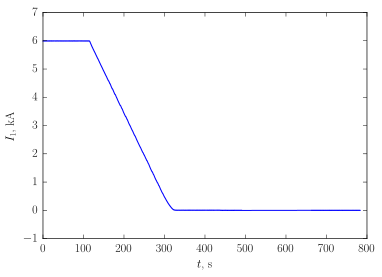

In [9]:
signal = "ArchiveDB/raw/W7X/CoDaStationDesc.84/DataModuleDesc.187_DATASTREAM/0/Current of  nonplanar Coils type 1 (AAE10)"
intervals = archivedb.get_all_time_intervals(signal, "2015-07-22 14:07:33","2015-08-13 14:20:33")

times, values = archivedb.get_all_signal(signal, intervals)

print "Timestamps: ", times, "\n"
print "Values: ", values
fig = figure()
plot((times-times[0])*1e-9, values*1e-3)
xlabel(r"$t$, s")
ylabel(r"$I_1$, kA")
show(fig)

## Many channels, single interval

First find time interval, e.g the lastest time interval, where signal values for one of the channel exists. 

*Note: since in a time interval, signal values for all the channels exist simultaneously*

This function returns a single time vector for all channels and a 2d array of data. In the 2d array, every row represents the signal values for one of the channels.

You can always pass an interval of your choice, but you cannot be sure if the signal values exist for that time window.

In [79]:
signal = ["http://archive-webapi.ipp-hgw.mpg.de","ArchiveDB","raw","W7X","CoDaStationDesc.114","DataModuleDesc.256_DATASTREAM","139", "ActVal_ADC01CP201"]
interval = archivedb.get_latest_time_interval(signal)
                                              
channels = [139,140,141,142]
time, values = archivedb.get_signal_box(signal[:-2], interval[0], interval[1], channels)

print "Timestamps: ", time, "\n"
print "Values for the channels: ","\n\n", values

Timestamps:  [1440423891135000000 1440423893136000000 1440423895138000000
 1440423897136000000 1440423899143000000] 

Values for the channels:  

[[ 0.022       0.022       0.022       0.022       0.022     ]
 [ 0.39999998  0.39999998  0.39999998  0.39999998  0.39999998]
 [ 0.62        0.62        0.61        0.61        0.62      ]
 [ 0.42000002  0.42000002  0.42000002  0.42000002  0.42000002]]


## Many channels,  many intervals

First find all the time intervals (2d array) in a time  window, where the signal values exist. Use just one channel to determine that.

Pass the time intervals, to get the signal values of your choice.

In the 2d array, every row represents signal values for one of the channels.

Each signal array contains the signal values corresponding to the ascending order of timestamps.

In [81]:
first_channel_signal ="http://archive-webapi.ipp-hgw.mpg.de/ArchiveDB/raw/W7X/CoDaStationDesc.84/DataModuleDesc.187_DATASTREAM/0/Current of nonplanar Coils type 5 (AAE56)"
x = archivedb.get_all_time_intervals(first_channel_signal,'2015-08-17 15:40:00','2015-08-18 04:40:00')

signalbox = "http://archive-webapi.ipp-hgw.mpg.de/ArchiveDB/raw/W7X/CoDaStationDesc.84/DataModuleDesc.187_DATASTREAM"
times, values = archivedb.get_all_signal_multinterval(signalbox, x, [0,1,2,3,4])

print "Timestamps: ", times, "\n"
print "Values for different channels: ", "\n", values

Timestamps:  [1439826000001205507 1439826000006205507 1439826000011205507 ...,
 1439872800216205507 1439872800221205507 1439872800226205507] 

Values for different channels:  
[[  1.27944740e+04   1.27928410e+04   1.27923520e+04 ...,   1.72429560e+00
   -1.25125840e+00  -1.67851370e-01]
 [  1.27933900e+04   1.27930390e+04   1.27923830e+04 ...,  -5.49333200e-01
   -4.62355470e+00   9.00296000e-01]
 [  1.27965340e+04   1.27975850e+04   1.27980150e+04 ...,  -3.37229590e+00
   -5.29496050e+00  -2.96029570e+00]
 [  1.27925790e+04   1.27935260e+04   1.27922000e+04 ...,   1.11392570e+00
    8.69777600e-01   1.28177750e+00]
 [  1.28023780e+04   1.27999800e+04   1.28008070e+04 ...,   3.35703600e+00
    2.15155500e+00   3.11288790e+00]]


## Library cache

The library provides a simplistic caching for exactly the same request. That is if the signal name and time intervals are the same as in a previous call, locally cached data will be delivered. This saves time and allows working with data locally if the network is not available.

Caching path can be changed in the archivedb module.
Whenever one requests for signal values, the values are stored in cache. Therefore, if one asks for the signal values for the same interval/intervals again, the process is faster.

To avoid writing to cache or reading from cache, add "False" as the last parameter to the functions, while reading the signal values.

In [82]:
signal = ["http://archive-webapi.ipp-hgw.mpg.de","ArchiveDB","raw","W7X","CoDaStationDesc.114","DataModuleDesc.256_DATASTREAM"]
channels = [139,140,141]

%time archivedb.get_signal_box(signal,1407920479822000000, 1407920481823000000, channels)
%time archivedb.get_signal_box(signal,1407920479822000000, 1407920481823000000, channels, False)

CPU times: user 5.35 ms, sys: 1.08 ms, total: 6.43 ms
Wall time: 46.5 ms
CPU times: user 4.91 ms, sys: 987 µs, total: 5.89 ms
Wall time: 1.21 s


(array([1407920479822000000, 1407920481823000000]),
 array([[ 0.0049    ,  0.0049    ],
        [ 0.96000004,  0.96000004],
        [ 0.5       ,  0.5       ]]))

## Write signal

The library allows to write signal data into database. This is presently possible only with the test branch of the database. Values for all the channels need to be passed while writing the signal values.

In the example, the signal has 2 channels, and we have 5 time stamps, So we pass a 2*5 2d array 

*Note: Cannot write in the past, once the signal receives newer values. For example: Cannot write on "2015-08-19 11:10:33" if the signal already has values at "2015-08-19 14:10:33".*

In [3]:
signal = 'http://archive-webapi.ipp-hgw.mpg.de/Test/raw/W7X/thoms_test/ADC1_DATASTREAM/'

my_timestamp = archivedb.to_timestamp("2015-08-21 10:15:33")
timestamps = [my_timestamp, my_timestamp+1, my_timestamp+2,my_timestamp+3,my_timestamp+4] # steps are in ns

archivedb.write_signal_json(signal ,timestamps, [[11,2,3,4,15],[1,2,3,4,5]])

True

The written signal can always be read back from the database.

In this example, we pass a smaller time window, so there are lesser timestamps and hence lesser signal values. (Lesser than the number of values written in the previous example)

In [4]:
signal = 'http://archive-webapi.ipp-hgw.mpg.de/Test/raw/W7X/thoms_test/ADC1_DATASTREAM/'
my_timestamp = archivedb.to_timestamp("2015-08-21 10:15:33")

time, values = archivedb.get_signal(signal, my_timestamp, my_timestamp+3)

print "Timestamps: ", time,"\n"
print "Values: ", values

Timestamps:  [1440152133000000000 1440152133000000001 1440152133000000002
 1440152133000000003] 

Values:  [[11  2  3  4]
 [ 1  2  3  4]]


# Image data

The library supports reading and writing images. For reading local caching is provided. An image can be read out in two forms either as a png or json. They are trasnfer protocols, the data returned to the user are always a 2d array. Png reading returns only the latest image in a time interval and its timestamp, whereas the json method returns all images. But the latter has a problem with unsigned data, that should corrected. It is advised to use png transfer and to use intervals found with one of methods provided by the library: intervals returned always contain only one image.

*Note: method get_latest_time_interval does not work with image signals, the other interval methods work*

* read an image from an interval - png read out with decoding, mention json has problems
* write image
* caching example

## Read image as png

We pass the interval in which we expect image/images.

The function returns the 2d array of the last image available in that time interval along with the timestamp when it was taken.

Timetaken:  2015-01-14 09:51:49.877000


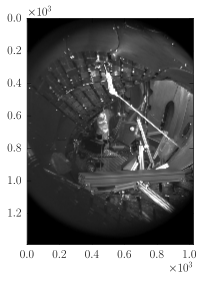

In [5]:
signal = ["http://archive-webapi.ipp-hgw.mpg.de","Test","raw","Data4SoftwareTest", "Hdf5.video.Test2", "pixelfly_DATASTREAM"]

interval = archivedb.get_lastfifty_time_intervals(signal, "2015-01-14 09:50:00", "2015-01-14 10:00:00")[0]

time, img = archivedb.get_image_png(signal ,interval[0],interval[1])

print "Timetaken: ", archivedb.to_stringdate(time)
figure()
gray()
imshow(img)
show()

## Read image as json

Reading image as json is slower, but it returns all the images (in a 3d array, i.e. array containing all 2d array of images) in the given time interval along with the timestamps when the **images** were taken.

Timetaken:  2015-01-14 09:51:49.877000


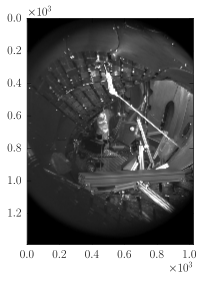

In [6]:
signal = ["http://archive-webapi.ipp-hgw.mpg.de","Test","raw","Data4SoftwareTest", "Hdf5.video.Test2", "pixelfly_DATASTREAM"]

interval = archivedb.get_lastfifty_time_intervals(signal, "2015-01-14 09:50:00", "2015-01-14 10:00:00")[0]
time, img = archivedb.get_image_json(signal , interval[0], interval[1])

print "Timetaken: ", archivedb.to_stringdate(time[0])
figure()
gray()
imshow(img[0])
show()

## Library cache

The library provide local caching for images in the same way as for signals, i.e. for exactly the same requests.

In [103]:
signal = ["http://archive-webapi.ipp-hgw.mpg.de","Test","raw","Data4SoftwareTest", "Hdf5.video.Test2", "pixelfly_DATASTREAM"]

interval = [archivedb.to_timestamp("2015-01-14 09:50:00"),archivedb.to_timestamp("2015-01-14 10:00:00")]
%time time, img = archivedb.get_image_png(signal ,interval[0],interval[1], False)
%time time, img = archivedb.get_image_png(signal ,interval[0],interval[1])

CPU times: user 339 ms, sys: 0 ns, total: 339 ms
Wall time: 1.07 s
CPU times: user 28.5 ms, sys: 0 ns, total: 28.5 ms
Wall time: 27.7 ms


## Write image

The library supports storing images into test database. Parameters should also be passed along with the image.
Parameters should be constructed in a dictionary. Image should be passed as a 2d array.

*Note: Cannot write in the past, once a newer image is written to the database. For example: cannot write on "2015-08-19 11:10:33" if there is already an image at "2015-08-19 14:10:33".*

In [108]:
im = PIL.Image.open("w7x.jpg")
width, height = im.size
image = np.array(im.getdata()).reshape(height, width, 3).sum(axis=-1)
d =  {"projectName":"test data", "cameraType":"test data",
      "height" : 287, "width" : 380,
      "bitDepth" : 10, "dataBoxSize" : 1,
      "datatype" : "short", "unsigned" : 1}
        
signal = "http://archive-webapi.ipp-hgw.mpg.de/Test/raw/W7XAnalysis/HDF5_import_test/"
archivedb.write_image_to_database(signal,archivedb.to_timestamp("2015-08-19 10:01:00"), image, d)

True

# Parameters

The library provides funcitions for reading and writing a set of parameters for a data stream.

* read out parameters
* write parameters

## Read parameters

Returns the parameters that existed for a signal in a given time interval in the form of a dictionary.

Dictionary has "dimensions", i.e. a list of timestamps when these parameters were prevalent. 

In [8]:
signal = "ArchiveDB/raw/W7X/CoDaStationDesc.14823/DataModuleDesc.14833_PARLOG/"
interval = [archivedb.to_timestamp("2015-08-03 12:25:00"),archivedb.to_timestamp("2015-08-03 12:25:10")]

print "Parameter Dictionary:","\n"
archivedb.get_parameters_box(signal, interval[0], interval[1])

Parameter Dictionary: 



{u'dimensions': [1438595611901000000, 1438604887005999999],
 u'label': u'parms',
 u'values': [{u'_source_class_name_': u'de.mpg.ipp.codac.business.schema.ParamSetFlexibleDataModule',
   u'chanDescs': {u'[0]': {u'_source_class_name_': u'de.mpg.ipp.codac.business.schema.ChannelDesc',
     u'active': 1,
     u'name': u'image',
     u'physicalQuantity': {u'_source_class_name_': u'de.mpg.ipp.codac.business.schema.InputRange',
      u'from': -10.0,
      u'type': u'V',
      u'upto': 10.0}}},
   u'className': u'ParamSetFlexibleDataModule',
   u'dataBoxElementLength': 1,
   u'dataBoxSize': 1,
   u'details': {u'[0]': {u'_source_class_name_': u'de.mpg.ipp.codac.business.schema.segment.ParameterString',
     u'actValue': u'image',
     u'id': 0,
     u'name': u'signalProviderSpecifier'},
    u'[1]': {u'_source_class_name_': u'de.mpg.ipp.codac.business.schema.segment.ParameterString',
     u'actValue': u'control',
     u'id': 0,
     u'name': u'controllableSpecifier'},
    u'[2]': {u'_source_clas

## Write parameters

Parameters along with the channel description should be **carefully** constructed in dictionary

In [7]:
my_timestamp = archivedb.to_timestamp("2015-08-20 10:00:00")
para_data = { 'chanDescs': 
                           {'[0]':
                                {
                                   'name' : 'Alpha', 
                                   'active' : 1, 
                                   'physicalQuantity' : { 'type' : 'X'}
                                },
                            '[1]' : 
                                {
                                   'name' : 'Beta', 
                                   'active' : 1, 
                                   'physicalQuantity' : { 'type' : 'X'}
                                }
                           },
                           'powerLevel' : 100
             } 

archivedb.write_parameters('Test/raw/W7XAnalysis/webapi-tests/pythonTest1_PARLOG/', para_data,
                               [my_timestamp, -1])

True

Here one also specified time interval where parameters are valid. "-1" stands for until next change.